## Preliminaries

In [1]:
# Load supporting functions.
import sys
sys.path.append('../')
from src import *

import quantus

/home/lweber/anaconda3/envs/eMRPT-notebook-test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


# Import libraries.
import torch
import os
import joblib

try:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Using device:', torch.cuda.get_device_name(0))
except:
    pass

Using device: NVIDIA TITAN RTX


### Define Experiment



In [3]:
# Define all the hyperparameters here
# Set the paramters marked with TODO to reproduce paper results
dataset_name = "imagenet"
model_names = ["vgg16", "resnet18"]
nr_test_samples = 1000
num_classes = 1000
batch_size = 16
data_path = "/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/Datasets/imagenet" #TODO Path to imagenet dataset
labelmap_path = "../src/label_map_imagenet.json"
savepath = "/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/tmp" #TODO Path to save results

recompute_results = True # Set this to False to only plot already computed results

xai_methods = [
   "SmoothGrad",
   "IntegratedGradients",
   "LRP-Eps",
   "LRP-Z+",
   "Guided-Backprop",
   "Gradient",
   "Saliency"
]
layer_orders = [
    "top_down",
    "bottom_up"
]

linewidth=2.5

In [4]:
os.makedirs(savepath, exist_ok=True)

# Get Dataset
# Prepare transforms
transform = get_transforms(dataset_name, mode="test")

# Prepare datasets
print("Preparing datasets...")
dataset = get_dataset(
    dataset_name,
    data_path,
    transform,
    mode="test",
    labelmap_path=labelmap_path
)

print(f"Number of Samples in Dataset: {len(dataset.samples)}")
dataset.samples = dataset.samples[:nr_test_samples]
print(f"Reduced of Samples in Dataset: {len(dataset.samples)}")

# Prepare dataloaders
print("Preparing dataloaders...")
loader = get_dataloader(
    dataset_name = dataset_name,
    dataset = dataset,
    batch_size = batch_size,
    shuffle = False,
)

Preparing datasets...
DATA_ROOT /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/Datasets/imagenet/val
Number of Samples in Dataset: 1000
Reduced of Samples in Dataset: 1000
Preparing dataloaders...


### Run Experiments

In [5]:
if recompute_results:

    for model_name in model_names:

        # Prepare model
        model = get_model(model_name, device)
        model.eval()

        XAI_METHOD_KWARGS = setup_xai_methods_zennit(xai_methods, model, device)

        for layer_order in layer_orders:

            for xai_method, xai_method_kwargs in XAI_METHOD_KWARGS.items():
                print(f"Computing MPRT-scores for model {model_name} with {layer_order} order using {xai_method} explanations")
                scores = {}

                if xai_method in ["SmoothGrad", "Saliency"]:
                    metric_kwargs = {
                        "abs": True, #Set abs preprocessing for XAI methods where the sign has no meaning
                        "normalise": True,
                        "normalise_func": quantus.normalise_by_average_second_moment_estimate,
                        "similarity_func": quantus.ssim,
                        "layer_order": layer_order,
                    }
                else:
                    metric_kwargs = {
                        "abs": False,
                        "normalise": True,
                        "normalise_func": quantus.normalise_by_average_second_moment_estimate,
                        "similarity_func": quantus.ssim,
                        "layer_order": layer_order,
                    }

                metric = quantus.MPRT(
                    **metric_kwargs
                )

                for i, (batch, labels) in enumerate(loader):

                    batch_results = metric(
                        model=model,
                        x_batch=batch.numpy(),
                        y_batch=labels.numpy(),
                        a_batch=None,
                        device=device,
                        explain_func=quantus.explain,
                        explain_func_kwargs={**{"method": xai_method}, **xai_method_kwargs}
                    )

                    for k in batch_results.keys():
                        if k not in scores.keys():
                            scores[k] = batch_results[k]
                        else:
                            scores[k] += batch_results[k]

                filepath = os.path.join(savepath, f"{model_name}--{layer_order}--{xai_method}--{nr_test_samples}.joblib")
                joblib.dump(scores, filepath)


/home/lweber/anaconda3/envs/eMRPT-notebook-test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lweber/anaconda3/envs/eMRPT-notebook-test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Computing MPRT-scores for model vgg16 with top_down order using SmoothGrad explanations
Computing MPRT-scores for model vgg16 with top_down order using IntegratedGradients explanations


### Plot From Result Files

In [ ]:
results = {}

for file in os.listdir(savepath):
    if file.endswith(".joblib"):
        mod_name = file.split("--")[0]
        l_order = file.split("--")[1]
        meth_name = file.split("--")[2]
        res = joblib.load(os.path.join(savepath, file))

        if mod_name not in results.keys():
            results[mod_name] = {}
        if l_order not in results[mod_name].keys():
            results[mod_name][l_order] = {}
        if meth_name not in results[mod_name][l_order].keys():
            results[mod_name][l_order][meth_name] = {}

        data = []
        layer_names = []

        for l, d in res.items():
            data.append(d)
            layer_names.append(l)

        results[mod_name][l_order]["layer_names"] = layer_names
        results[mod_name][l_order][meth_name] = data

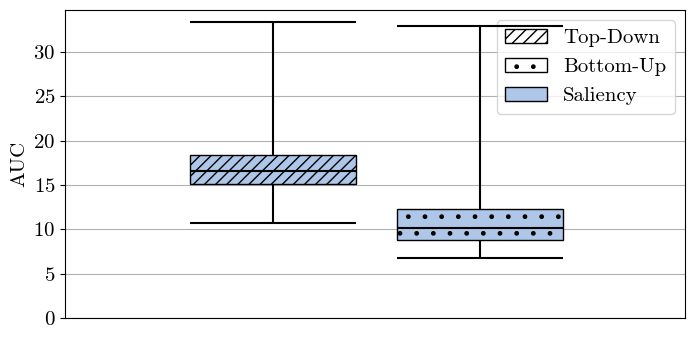

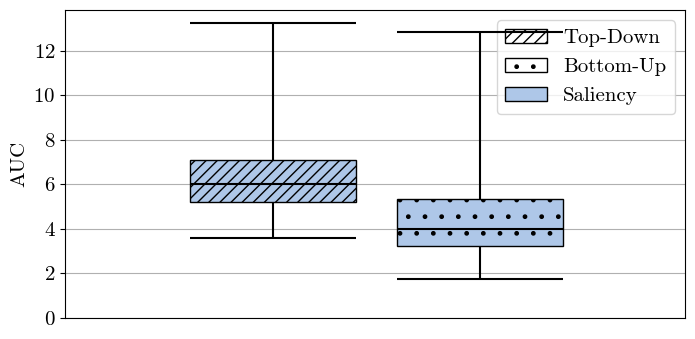

In [ ]:

for mod_name, mod_res in results.items():

    fig, ax = plt.subplots(figsize=(8, 4))

    ax.set_xlabel("")
    ax.set_ylabel("AUC")
    ax.set_xticks([])
    ax.grid(True)

    x_idx = 0
    for m, meth_name in enumerate(COLOR_MAP.keys()):

        for l, l_order in enumerate(HATCH_MAP.keys()):

            if l_order not in mod_res.keys():
                continue
            l_res = mod_res[l_order]
            if meth_name not in l_res.keys():
                continue

            res = l_res[meth_name]
            data = np.array(results[mod_name][l_order][meth_name])
            aucs = np.trapz(data, axis=0)
            auc_min = np.min(aucs)
            auc_25 = np.percentile(aucs, q=25)
            auc_50 = np.percentile(aucs, q=50)
            auc_75 = np.percentile(aucs, q=75)
            auc_max = np.max(aucs)
            color = COLOR_MAP[meth_name]
            hatch = HATCH_MAP[l_order]

            ax.bar(x_idx, auc_75-auc_25, bottom=auc_25, color=color, edgecolor="black", hatch=hatch, zorder=10)

            ax.hlines(auc_50, xmin=x_idx-0.4, xmax=x_idx+0.4, color="black", zorder=10)

            ax.hlines(auc_min, xmin=x_idx-0.4, xmax=x_idx+0.4, color="black", zorder=10)
            ax.vlines(x_idx, ymin=auc_min, ymax=auc_25, color="black", zorder=10)
            ax.hlines(auc_max, xmin=x_idx-0.4, xmax=x_idx+0.4, color="black", zorder=10)
            ax.vlines(x_idx, ymin=auc_75, ymax=auc_max, color="black", zorder=10)

            x_idx += 1

     # Make Legend
    leg_lines = []
    HM_keys = [hm for hm in HATCH_MAP.keys() if hm in mod_res.keys()]
    for l in HM_keys:
        label = LAYER_ORDER_MAP[l]
        leg_lines.append(ax.bar(-10, 0, bottom=auc_50, edgecolor="black", color="white", hatch=HATCH_MAP[l], label=label))
    MK_KEYS = [mk for mk in COLOR_MAP.keys() if mk in l_res.keys()]
    for m in MK_KEYS:
        label=f"{m}"
        leg_lines.append(ax.bar(-10, 0, bottom=auc_50, edgecolor="black", color=COLOR_MAP[m], label=label))
    ax.legend()

    ax.set_xlim(left=-1)
    ax.set_ylim(bottom=0)

    fig.savefig(os.path.join(savepath, f"layerorder-methodresults-{mod_name}.svg"))

    plt.show()

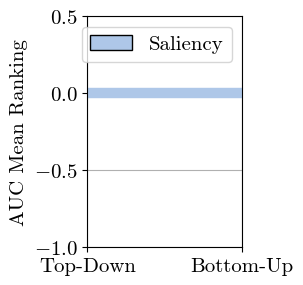

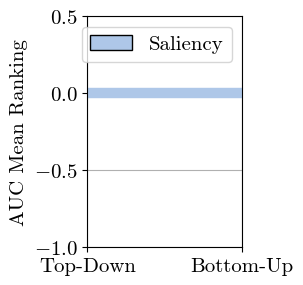

In [ ]:
for mod_name, mod_res in results.items():

    fig, ax = plt.subplots(figsize=(2, 3))

    ax.set_xlabel("")
    ax.set_ylabel("AUC Mean Ranking")
    ax.grid(True)

    ranking = {}
    for l, l_order in enumerate(HATCH_MAP.keys()):
        tmp_means = []
        for m, meth_name in enumerate(COLOR_MAP.keys()):

            if l_order not in mod_res.keys():
                continue
            l_res = mod_res[l_order]
            if meth_name not in l_res.keys():
                continue

            res = l_res[meth_name]
            data = np.array(results[mod_name][l_order][meth_name])
            aucs = np.trapz(data, axis=0)

            tmp_means.append(np.mean(aucs))

        sorting = np.argsort(tmp_means)
        sorting = sorting[::-1]
        methods = [mk for mk in list(COLOR_MAP.keys()) if mk in l_res.keys()]

        for i, s in enumerate(sorting):
            if methods[s] not in ranking.keys():
                ranking[methods[s]] = []
            ranking[methods[s]].append(i)

    for method, values in ranking.items():
        ax.plot([0, 1], values, alpha=1.0, linewidth=linewidth*3, marker="", color=COLOR_MAP[method])


    HM_keys = [LAYER_ORDER_MAP[hm] for hm in HATCH_MAP.keys() if hm in mod_res.keys()]
    ax.set_xticks([0, 1])
    ax.set_xticklabels(HM_keys)

    # Make Legend
    leg_lines = []
    MK_KEYS = [mk for mk in COLOR_MAP.keys() if mk in l_res.keys()]
    for m in MK_KEYS:
        label=f"{m}"
        leg_lines.append(ax.bar(-10, 0, bottom=-10, edgecolor="black", color=COLOR_MAP[m], label=label))
    ax.legend()

    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=-1)

    fig.savefig(os.path.join(savepath, f"layerorder-rankingresults-{mod_name}.svg"))

    plt.show()